## Import Dependencies

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LSTM, Flatten, Dropout, Dense, TimeDistributed
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Select Randomness

In [2]:
# Set a random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

## Set Dataset Variables

In [3]:
# Define the dataset path
dataset_path = '/kaggle/input/dcsass-dataset/DCSASS Dataset'

# Define dataset parameters
VIS_FRAME_WIDTH = 224
VIS_FRAME_HEIGHT = 224
FRAME_WIDTH = 112              # Width of each frame
FRAME_HEIGHT = 112             # Height of each frame
SEQUENCE_LENGTH = 16            # Number of frames in each sequence
BATCH_SIZE = 8                 # Batch size for training
TRAIN_RATIO = 0.7               # Training data ratio
VAL_RATIO = 0.15               # Validation data ratio
TEST_RATIO = 0.15               # Testing data ratio

# Map each class to a numeric label
classes = [name for name in os.listdir(dataset_path) if name != 'Labels']
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

# Get all class names (categories) in the dataset, excluding "Labels"
all_classes_names = [name for name in os.listdir(dataset_path) if name != 'Labels']

# Display the mapping of classes to indices for verification
print("Class to index mapping:", class_to_idx)

Class to index mapping: {'RoadAccidents': 0, 'Assault': 1, 'Vandalism': 2, 'Arrest': 3, 'Shooting': 4, 'Arson': 5, 'Explosion': 6, 'Shoplifting': 7, 'Robbery': 8, 'Stealing': 9, 'Burglary': 10, 'Abuse': 11, 'Fighting': 12}


## View Dataset

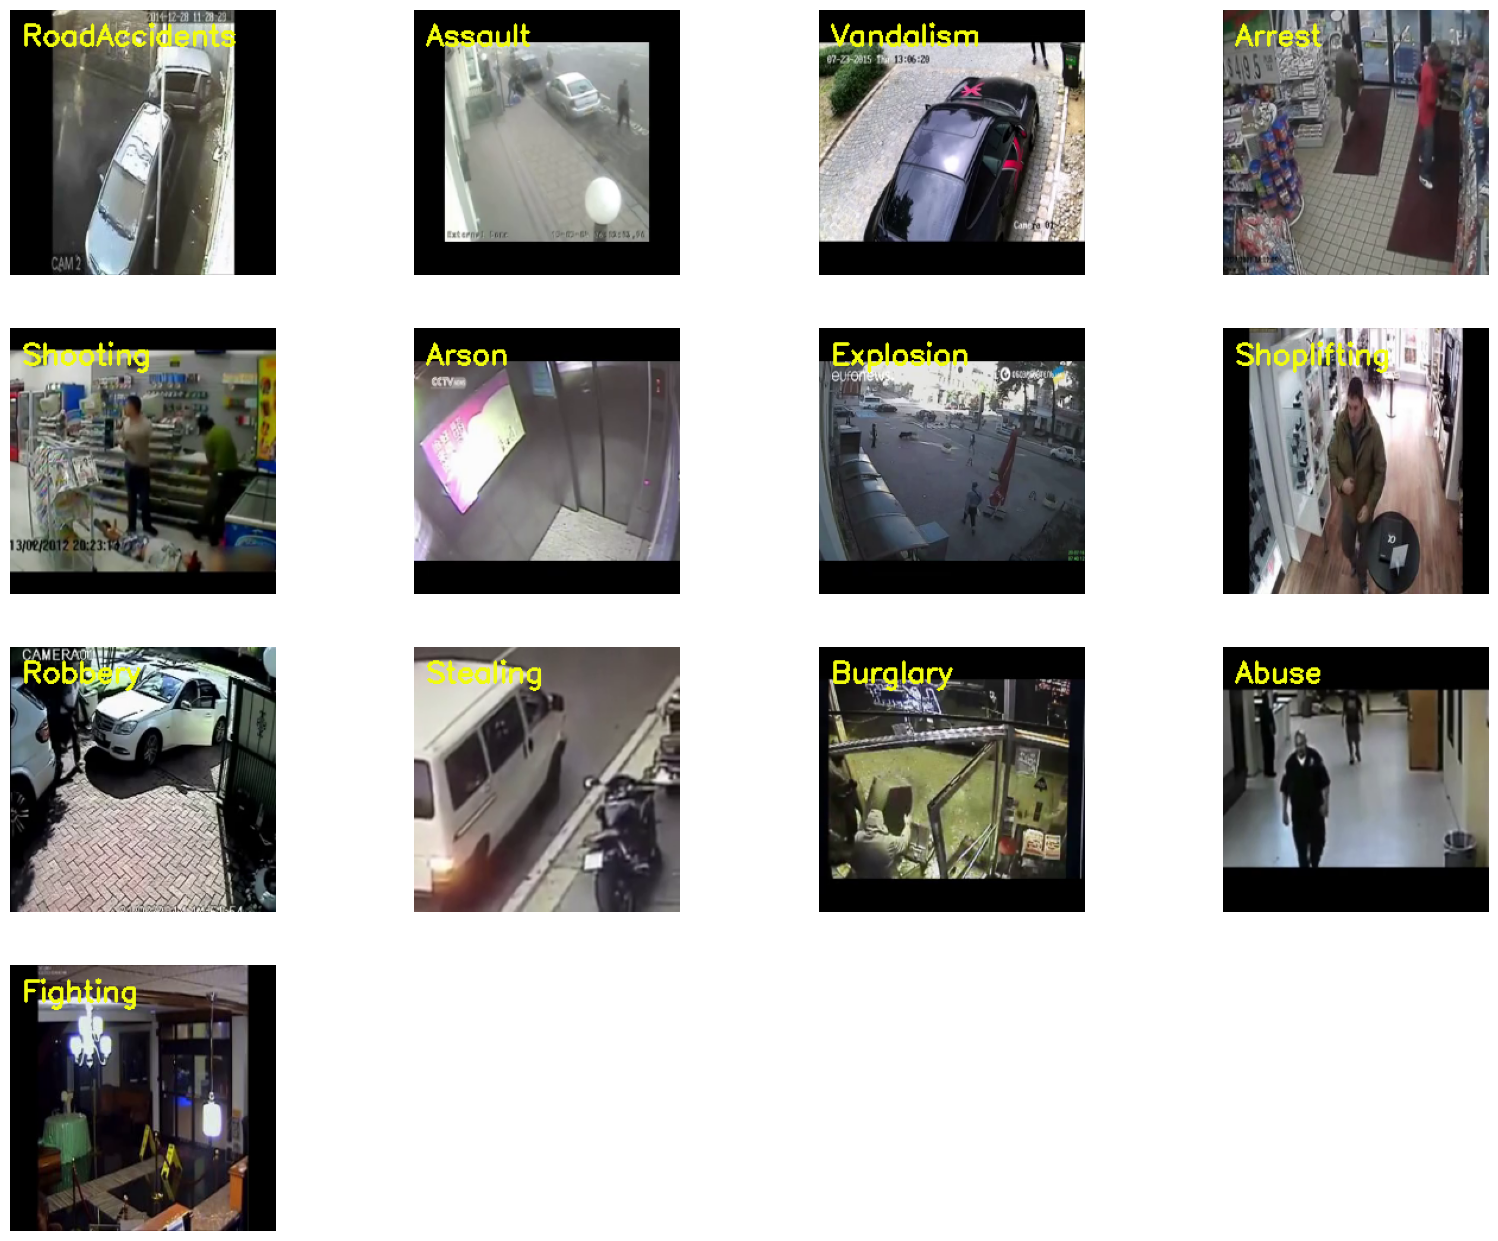

In [4]:
# Set up the Matplotlib figure for displaying frames
plt.figure(figsize=(20, 20))

# Iterate through each class and display a sample frame
for counter, class_name in enumerate(all_classes_names, 1):
    # Get all scene directories within the current class
    class_path = os.path.join(dataset_path, class_name)    

    if os.path.isdir(class_path):
        scenes = os.listdir(class_path)
        
        # Select a random scene directory from this class
        selected_scene = random.choice(scenes)
        scene_path = os.path.join(class_path, selected_scene)

        # Get all video clips within this scene directory
        video_files = [f for f in os.listdir(scene_path) if f.endswith('.mp4')]

        # Randomly select a video file from the chosen scene
        selected_video_file = random.choice(video_files)
        video_path = os.path.join(scene_path, selected_video_file)

        # Initialize a VideoCapture object to read from the selected video file
        video_reader = cv2.VideoCapture(video_path)

        # Set to a middle frame (e.g., frame 25) to display
        video_reader.set(1, 25)

        # Read the frame
        success, bgr_frame = video_reader.read()
        video_reader.release()  # Release the VideoCapture object     

        # Check if the frame was successfully read
        if success:
            # Resize the frame for consistency
            bgr_frame = cv2.resize(bgr_frame, (VIS_FRAME_WIDTH, VIS_FRAME_WIDTH))

            # Convert BGR to RGB format for displaying
            rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

            # Annotate the frame with the class name
            cv2.putText(rgb_frame, class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (241, 252, 15), 2)

            # Display the frame
            plt.subplot(5, 4, counter)
            plt.imshow(rgb_frame)
            plt.axis('off')

plt.show()

## Configure parallel GPU usage for tensorflow

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Number of GPUs available: {len(gpus)}")
    for gpu in gpus:
        print(f"GPU: {gpu}")
else:
    print("No GPUs available.")

strategy = tf.distribute.MirroredStrategy()

Number of GPUs available: 2
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


## Data Preprocessing

In [6]:
def preprocess_video(video_path, sequence_length, frame_width, frame_height):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened() and len(frames) < sequence_length:
        ret, frame = cap.read()
        if not ret:
            break

        # Resize the frame
        frame = cv2.resize(frame, (frame_width, frame_height))

        # Convert to grayscale for CLAHE enhancement
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_frame = clahe.apply(gray_frame)

        # Normalize the frame and add to the sequence list
        normalized_frame = enhanced_frame / 255.0  # Normalize to [0, 1]
        frames.append(normalized_frame)

    cap.release()

    # Padding: If fewer frames are extracted, add empty frames
    if len(frames) < sequence_length:
        padding = [np.zeros((frame_height, frame_width))] * (sequence_length - len(frames))
        frames.extend(padding)

    return np.array(frames)  # Returns a sequence of frames as a numpy array

def load_dataset(dataset_path, classes, class_to_idx, sequence_length, frame_width, frame_height, max_scenes=2, max_videos_per_scene=2):
    data = []
    labels = []

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        scenes = os.listdir(class_path)

        # Randomly sample up to max_scenes scenes per class
        sampled_scenes = random.sample(scenes, min(max_scenes, len(scenes)))

        for scene in sampled_scenes:
            scene_path = os.path.join(class_path, scene)
            video_files = [f for f in os.listdir(scene_path) if f.endswith('.mp4')]

            # Randomly sample up to max_videos_per_scene videos per scene
            sampled_videos = random.sample(video_files, min(max_videos_per_scene, len(video_files)))

            for video_file in sampled_videos:
                video_path = os.path.join(scene_path, video_file)

                # Preprocess the video to get the frames as a sequence
                frames = preprocess_video(video_path, sequence_length, frame_width, frame_height)

                # Append the frames and corresponding label
                data.append(frames)
                labels.append(class_to_idx[class_name])

    # Convert lists to numpy arrays for easier handling
    return np.array(data), np.array(labels)


In [7]:
# Load a smaller subset of the dataset
data, labels = load_dataset(
    dataset_path=dataset_path,
    classes=all_classes_names,
    class_to_idx=class_to_idx,
    sequence_length=SEQUENCE_LENGTH,
    frame_width=FRAME_WIDTH,
    frame_height=FRAME_HEIGHT,
    max_scenes=8,
    max_videos_per_scene=32
)

# Check the shape of the data and labels
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
print("Sample label distribution:", np.bincount(labels))  # Check distribution of classes in the dataset

Data shape: (3328, 16, 112, 112)
Labels shape: (3328,)
Sample label distribution: [256 256 256 256 256 256 256 256 256 256 256 256 256]


## Model Creation [ LRCN - Long-term Recurrent Convolutional Network ]

In [8]:
def build_lrcn_model(frame_width, frame_height, sequence_length, num_classes):
    model = Sequential()

    # TimeDistributed CNN Layers (Feature Extraction)
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=(sequence_length, frame_height, frame_width, 1)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # Flatten before passing to LSTM
    model.add(TimeDistributed(Flatten()))

    # LSTM Layers (Temporal Analysis)
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.5))  # Dropout for regularization

    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))  # Additional Dropout for further regularization

    # Dense Layers (Classification)
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for final dense layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Build the model
num_classes = len(class_to_idx)
model = build_lrcn_model(FRAME_WIDTH, FRAME_HEIGHT, SEQUENCE_LENGTH, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model architecture
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 16, 112, 112,   │           320 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 112, 112,   │           128 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 56, 56, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 56, 56, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 16, 56, 56, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 16, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 16, 28, 28,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 16, 28, 28,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 16, 14, 14,     │             0 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 16, 25088)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16, 256)        │    25,953,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,262,157 (100.18 MB)

 Trainable params: 26,261,709 (100.18 MB)

 Non-trainable params: 448 (1.75 KB)

## Model Training

In [9]:
# Split the data into training, validation, and test sets
train_data, temp_data, train_labels, temp_labels = train_test_split(data, labels, test_size=(VAL_RATIO + TEST_RATIO), random_state=SEED)
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=(TEST_RATIO / (VAL_RATIO + TEST_RATIO)), random_state=SEED)

# Train the model
history = model.fit(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    batch_size=BATCH_SIZE,
    epochs=30  # Adjust epochs as needed
)

Epoch 1/30
292/292 ━━━━━━━━━━━━━━━━━━━━ 109s 312ms/step - accuracy: 0.1055 - loss: 2.6269 - val_accuracy: 0.2164 - val_loss: 2.3271
Epoch 2/30
292/292 ━━━━━━━━━━━━━━━━━━━━ 88s 301ms/step - accuracy: 0.2118 - loss: 2.3368 - val_accuracy: 0.3427 - val_loss: 1.8466
Epoch 3/30
292/292 ━━━━━━━━━━━━━━━━━━━━ 88s 302ms/step - accuracy: 0.3994 - loss: 1.8481 - val_accuracy: 0.5731 - val_loss: 1.3303
Epoch 4/30
292/292 ━━━━━━━━━━━━━━━━━━━━ 88s 302ms/step - accuracy: 0.5503 - loss: 1.4333 - val_accuracy: 0.7455 - val_loss: 0.8127
Epoch 5/30
292/292 ━━━━━━━━━━━━━━━━━━━━ 88s 303ms/step - accuracy: 0.6879 - loss: 1.0312 - val_accuracy: 0.7695 - val_loss: 0.6936
Epoch 6/30
292/292 ━━━━━━━━━━━━━━━━━━━━ 88s 303ms/step - accuracy: 0.7297 - loss: 0.8572 - val_accuracy: 0.8277 - val_loss: 0.6380
Epoch 7/30
292/292 ━━━━━━━━━━━━━━━━━━━━ 88s 303ms/step - accuracy: 0.8367 - loss: 0.6351 - val_accuracy: 0.9058 - val_loss: 0.3743
Epoch 8/30
292/292 ━━━━━━━━━━━━━━━━━━━━ 88s 303ms/step - accuracy: 0.8566 - loss: 

## Plot Loss and Accuracy Graphs

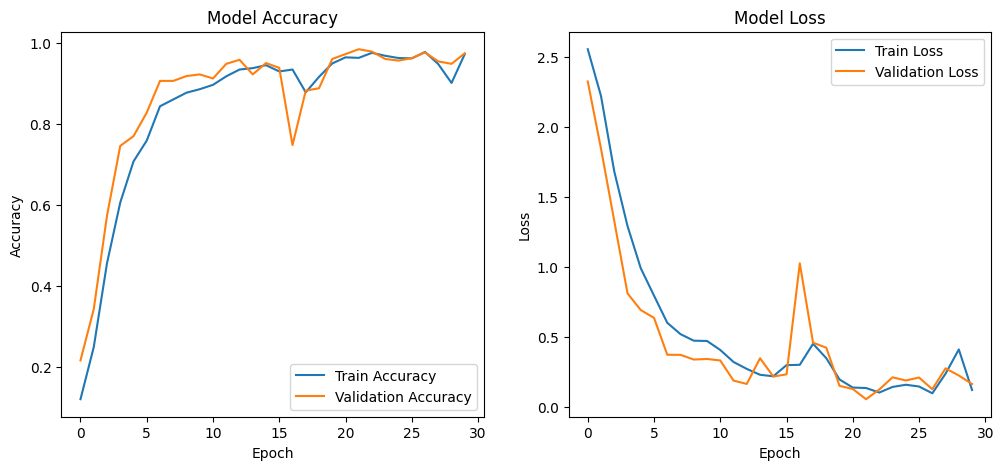

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [11]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data, test_labels, batch_size=BATCH_SIZE, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9785 - loss: 0.1044
Test Loss: 0.1360
Test Accuracy: 0.9720


## Save Model for Downloading

In [12]:
model.save('/kaggle/working/my_model.h5')

## Plot Confusion Matrix 

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step


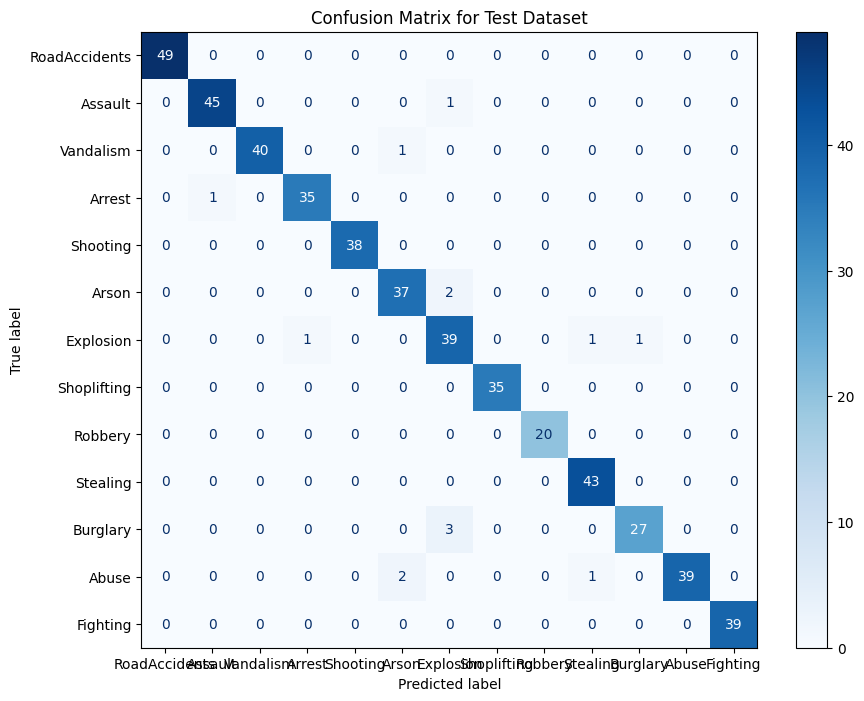

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the test set
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(test_labels, y_pred_classes)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_classes_names)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title("Confusion Matrix for Test Dataset")
plt.show()


## Plot Classification Report

In [14]:
from sklearn.metrics import classification_report

# Generate a classification report
class_report = classification_report(test_labels, y_pred_classes, target_names=all_classes_names)
print("Classification Report:\n")
print(class_report)

Classification Report:

               precision    recall  f1-score   support

RoadAccidents       1.00      1.00      1.00        49
      Assault       0.98      0.98      0.98        46
    Vandalism       1.00      0.98      0.99        41
       Arrest       0.97      0.97      0.97        36
     Shooting       1.00      1.00      1.00        38
        Arson       0.93      0.95      0.94        39
    Explosion       0.87      0.93      0.90        42
  Shoplifting       1.00      1.00      1.00        35
      Robbery       1.00      1.00      1.00        20
     Stealing       0.96      1.00      0.98        43
     Burglary       0.96      0.90      0.93        30
        Abuse       1.00      0.93      0.96        42
     Fighting       1.00      1.00      1.00        39

     accuracy                           0.97       500
    macro avg       0.97      0.97      0.97       500
 weighted avg       0.97      0.97      0.97       500

